In [1]:
%load_ext autoreload
%autoreload 2

from nnTrain import train_efn, train_pfn, get_data
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow import keras
from keras import backend as K
from energyflow.utils import data_split, to_categorical
from sklearn.model_selection import train_test_split
import gc
from tensorflow.keras.losses import BinaryCrossentropy

# define rng seeds for train/test/val split for replicable results
rng1 = 45446
rng2 = 25135

2023-09-13 23:55:31.465556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Quark jets, R = 0.8

In [3]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('q',hlevel=True,efrac=False,base=base,nmax=nmax)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('q',hlevel=False,efrac=False,base=base,nmax=nmax)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set3_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2qq_set4_R1.0_mH1000_pTall.h5


In [ ]:
# Regular PFN, no spectral normalization
for i in range(5,11):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":100,"verbose":1,"batch_size":512}
    pfn, auc, pfn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    pfn.save(f"keras_models_PFN/qjet_PFN_zpT_iter{i}.keras")
    del pfn
    gc.collect()

In [ ]:
# Spectral PFN
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    pfn, auc, pfn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    pfn.save(f"keras_models_PFN/qjet_spectralPFN_zpT_iter{i}.keras")
    del pfn
    gc.collect()

# Gluon jets, R = 0.8

In [2]:
base="/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/"
nmax = 200000

hdata = get_data('g',hlevel=True,efrac=False,base=base,nmax=nmax)
htrain, htest = train_test_split(hdata,train_size=0.5,random_state=rng1)
htest, hval = train_test_split(htest,train_size=0.5,random_state=rng2)

pdata = get_data('g',hlevel=False,efrac=False,base=base,nmax=nmax)
ptrain, ptest = train_test_split(pdata,train_size=0.5,random_state=rng1)
ptest, pval = train_test_split(ptest,train_size=0.5,random_state=rng2)

train = np.concatenate((htrain,ptrain),axis=0)
train_labels = np.concatenate((np.ones((htrain.shape[0],1)),np.zeros((ptrain.shape[0],1))),axis=0)
perm = np.random.permutation(train.shape[0])
train = train[perm]
train_labels = train_labels[perm]

test = np.concatenate((htest,ptest),axis=0)
test_labels = np.concatenate((np.ones((htest.shape[0],1)),np.zeros((ptest.shape[0],1))),axis=0)
perm = np.random.permutation(test.shape[0])
test = test[perm]
test_labels = test_labels[perm]

val = np.concatenate((hval,pval),axis=0)
val_labels = np.concatenate((np.ones((hval.shape[0],1)),np.zeros((pval.shape[0],1))),axis=0)
perm = np.random.permutation(val.shape[0])
val = val[perm]
val_labels = val_labels[perm]

del hdata, pdata, htrain, htest, hval, ptrain, ptest, pval, perm

Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall.h5
Loading:
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set4_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set0_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set1_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set2_R1.0_mH1000_pTall.h5
/uscms/home/sbrightt/nobackup/jets-ml/datasets/safeIncalculable_v2/h2gg_set3_R1.0_mH1000_pTall.h5


2023-09-13 23:58:56.518926: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-13 23:59:00.859011: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-13 23:59:00.859736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-13 23:59:00.861261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     240         ['input[0][0]']                  
                                                                                                  
 activation (Activation)        (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     3660        ['activation[0][0]']             
                                                                                              

2023-09-13 23:59:22.490756: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


391/391 [==============================] - 15s 11ms/step - loss: 0.1997 - acc: 0.9253 - val_loss: 0.0679 - val_acc: 0.9769
Epoch 2/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0764 - acc: 0.9744 - val_loss: 0.0640 - val_acc: 0.9784
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0699 - acc: 0.9767 - val_loss: 0.0607 - val_acc: 0.9794
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0660 - acc: 0.9784 - val_loss: 0.0633 - val_acc: 0.9789
Epoch 5/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0633 - acc: 0.9793 - val_loss: 0.0728 - val_acc: 0.9750
Epoch 6/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0622 - acc: 0.9795 - val_loss: 0.0591 - val_acc: 0.9802
Epoch 7/100
391/391 [==============================] - 4s 9ms/step - loss: 0.0600 - acc: 0.9807 - val_loss: 0.0598 - val_acc: 0.9800
Epoch 8/100
391/391 [==============================] - 3s 9ms/step - loss: 0.05

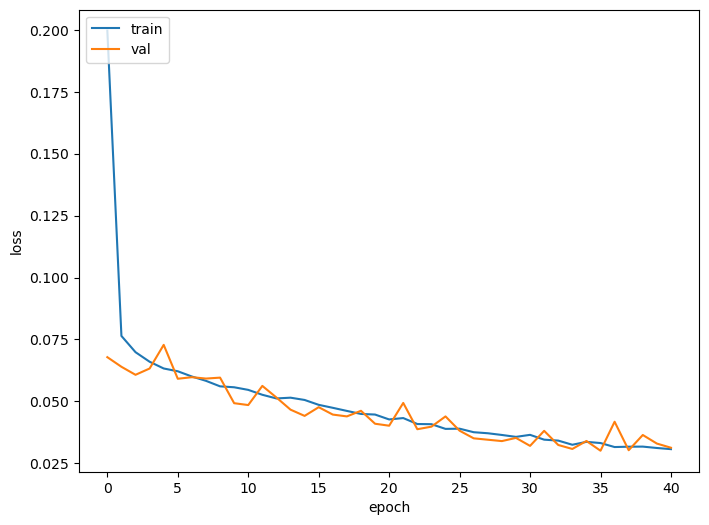

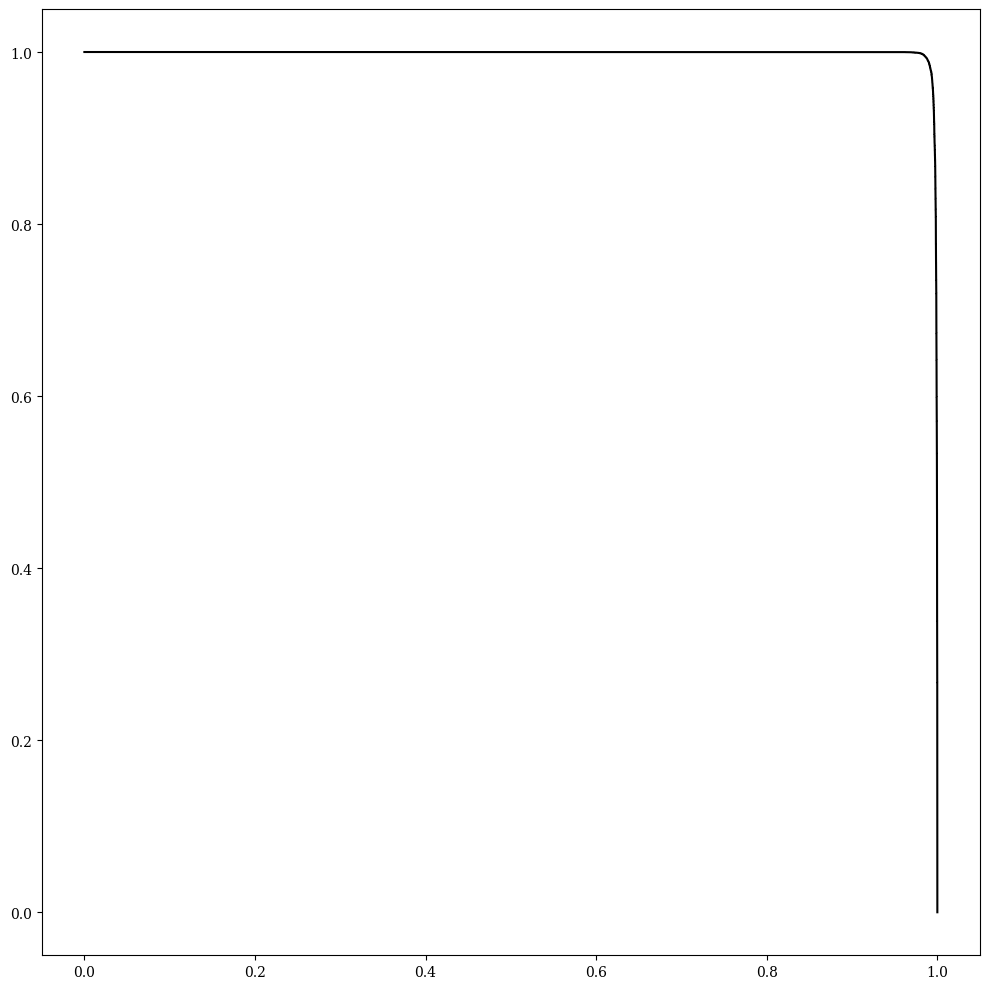

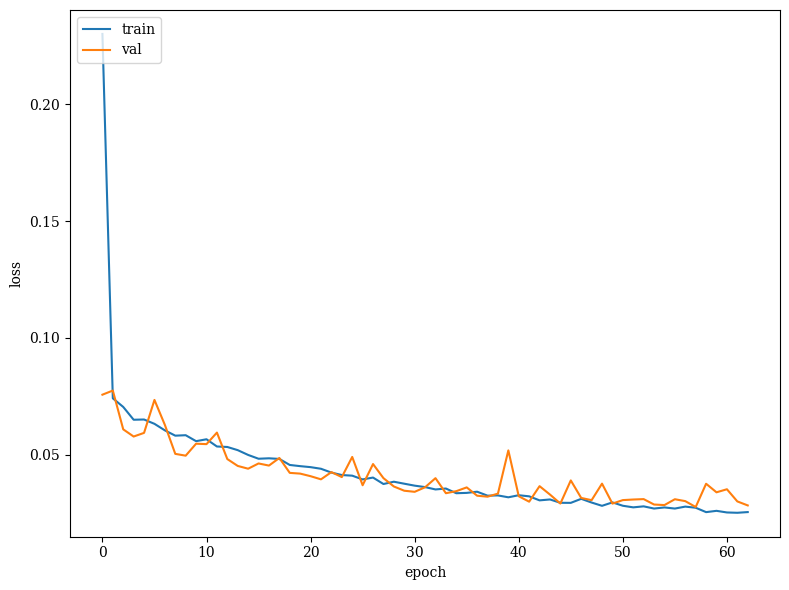

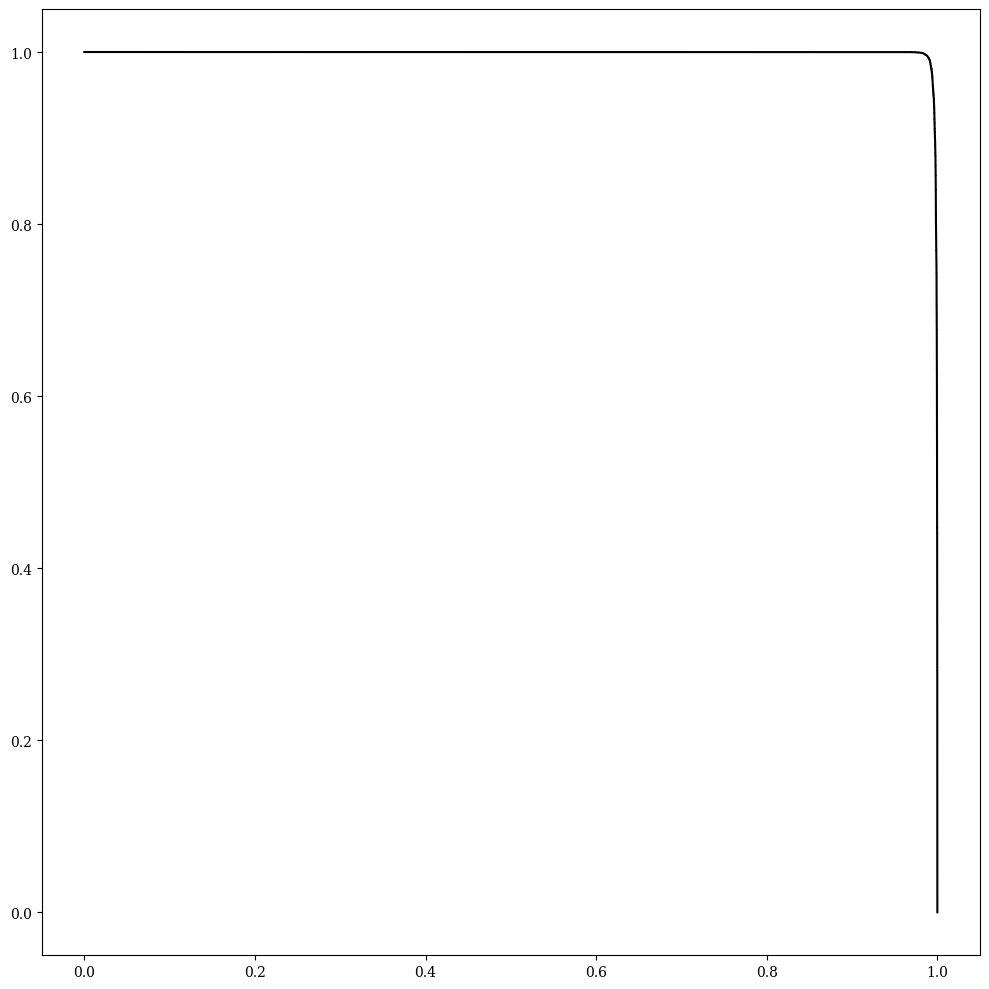

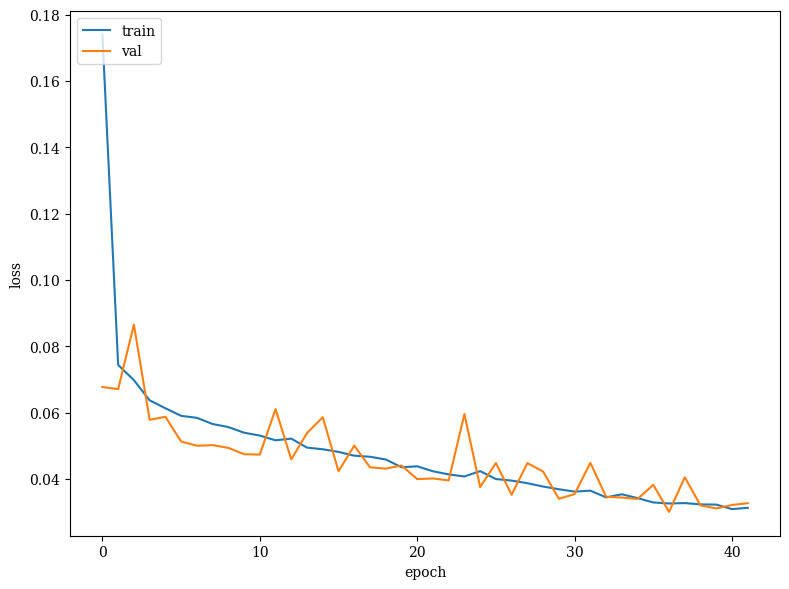

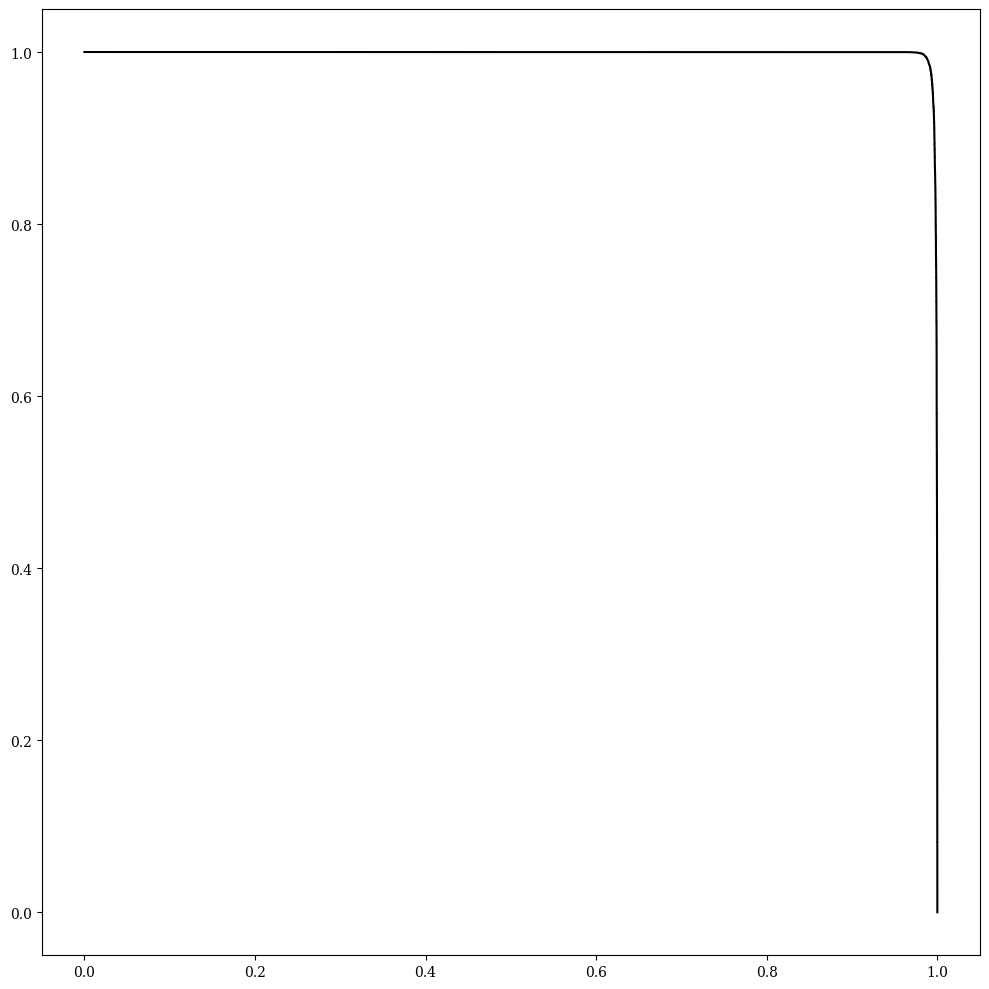

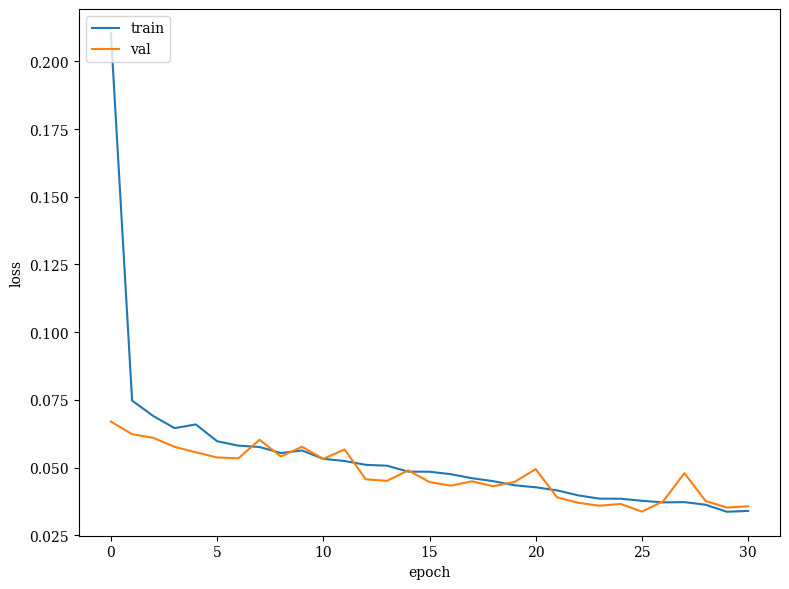

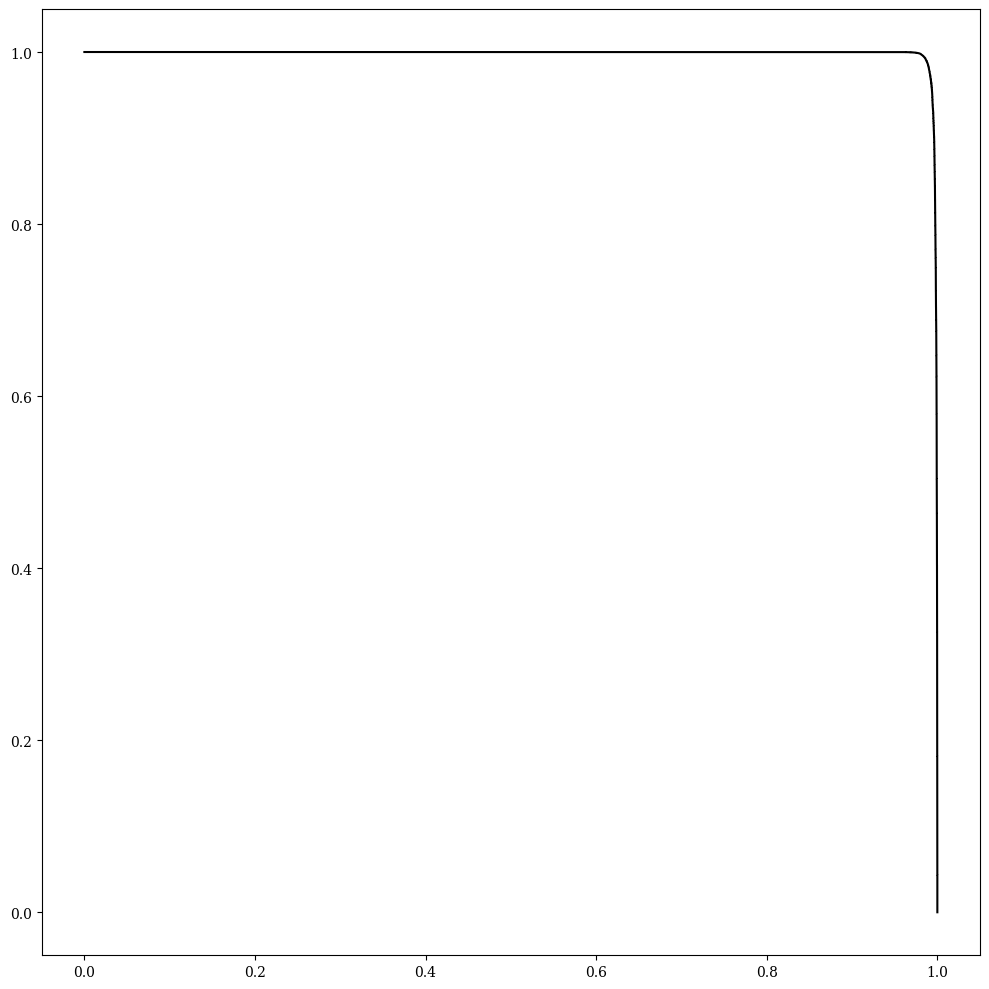

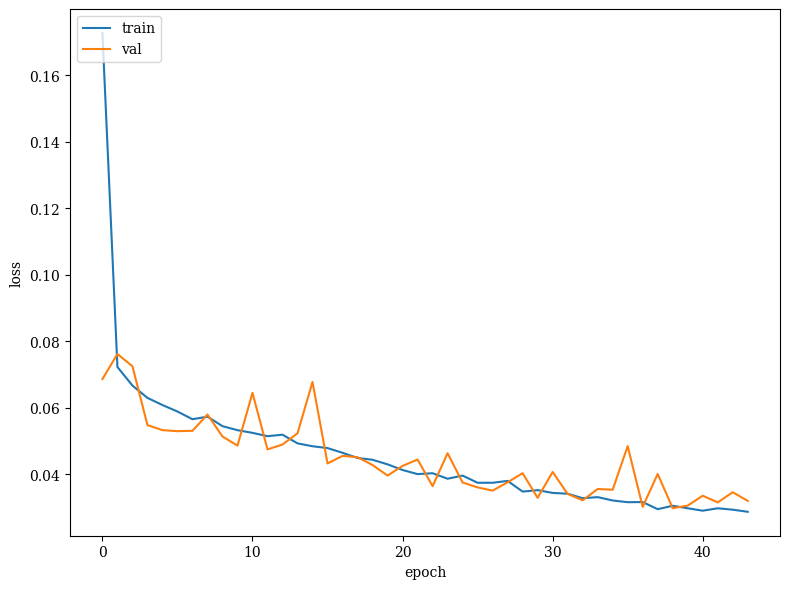

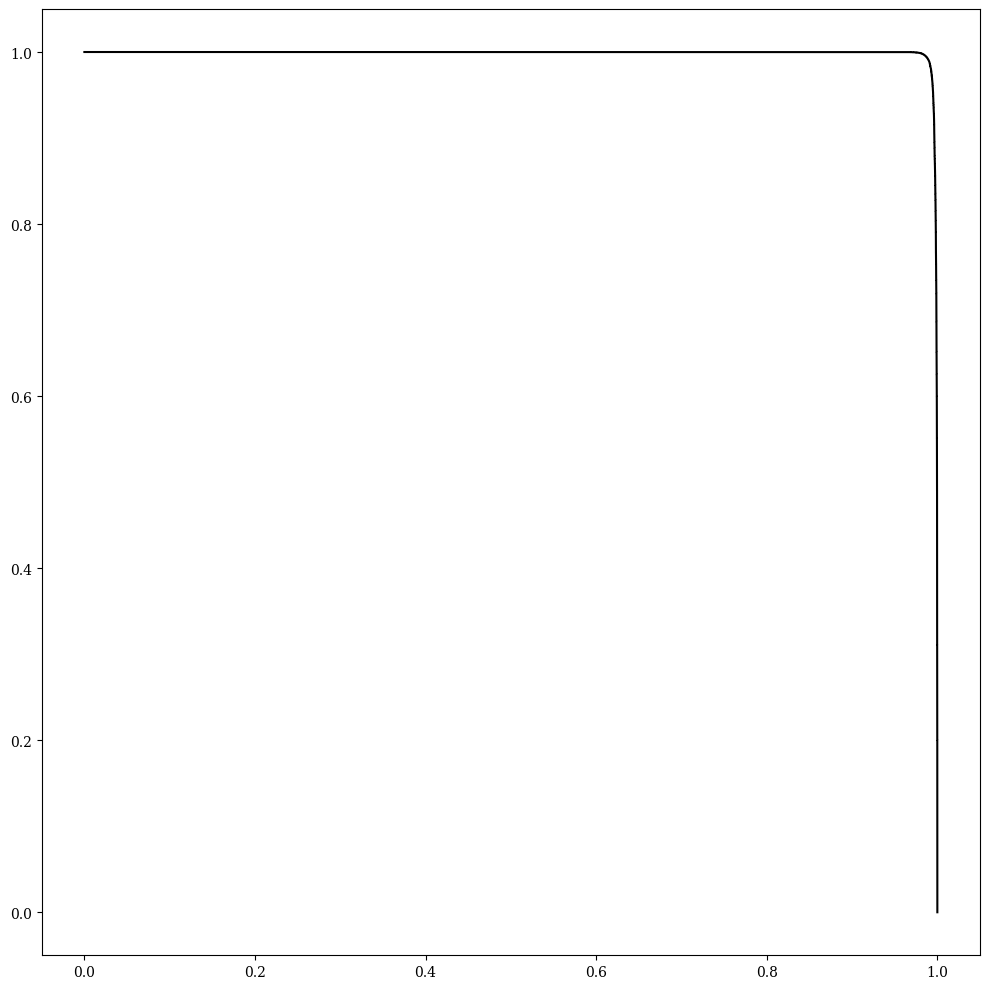

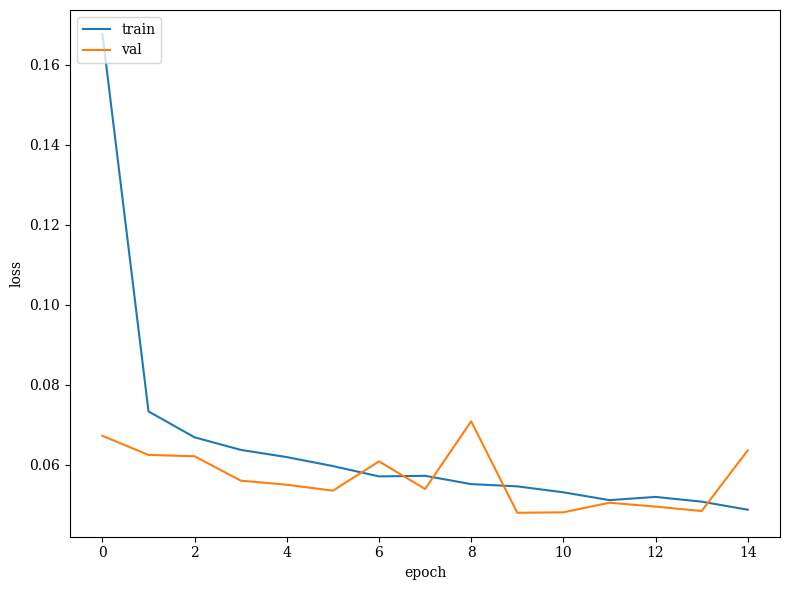

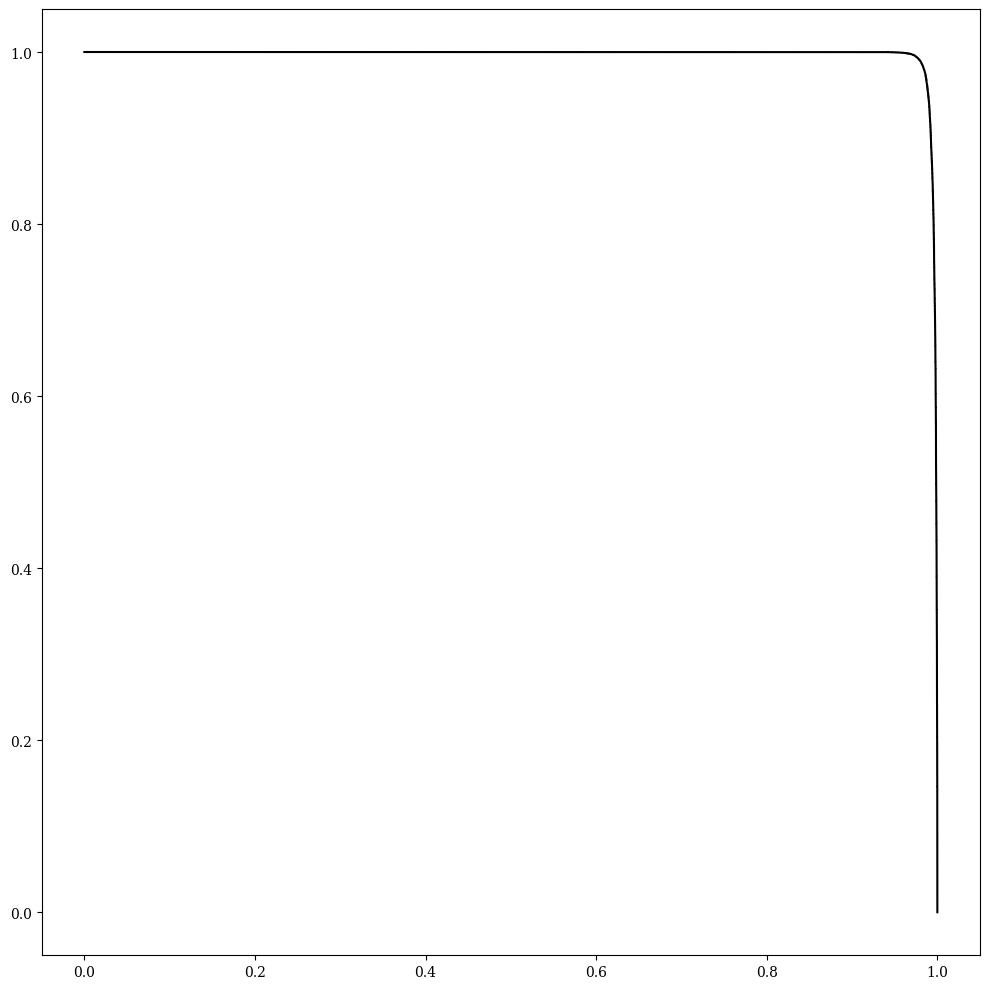

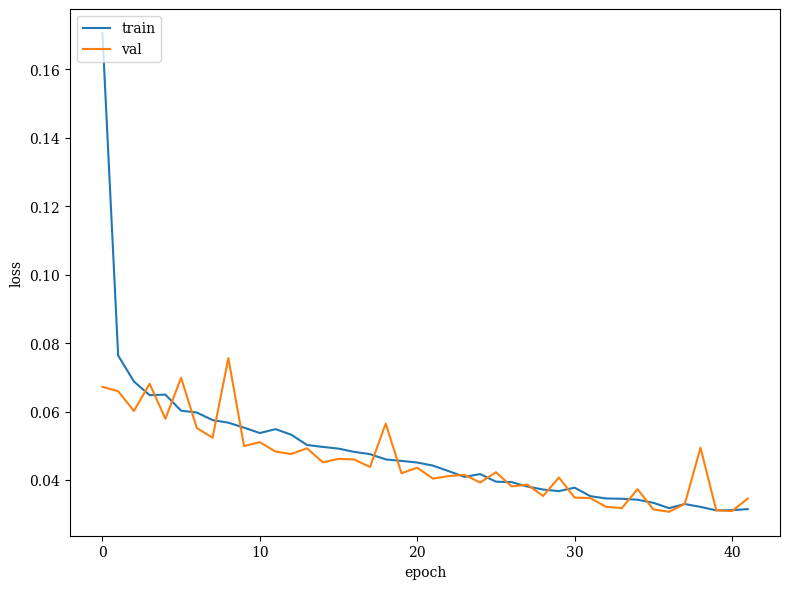

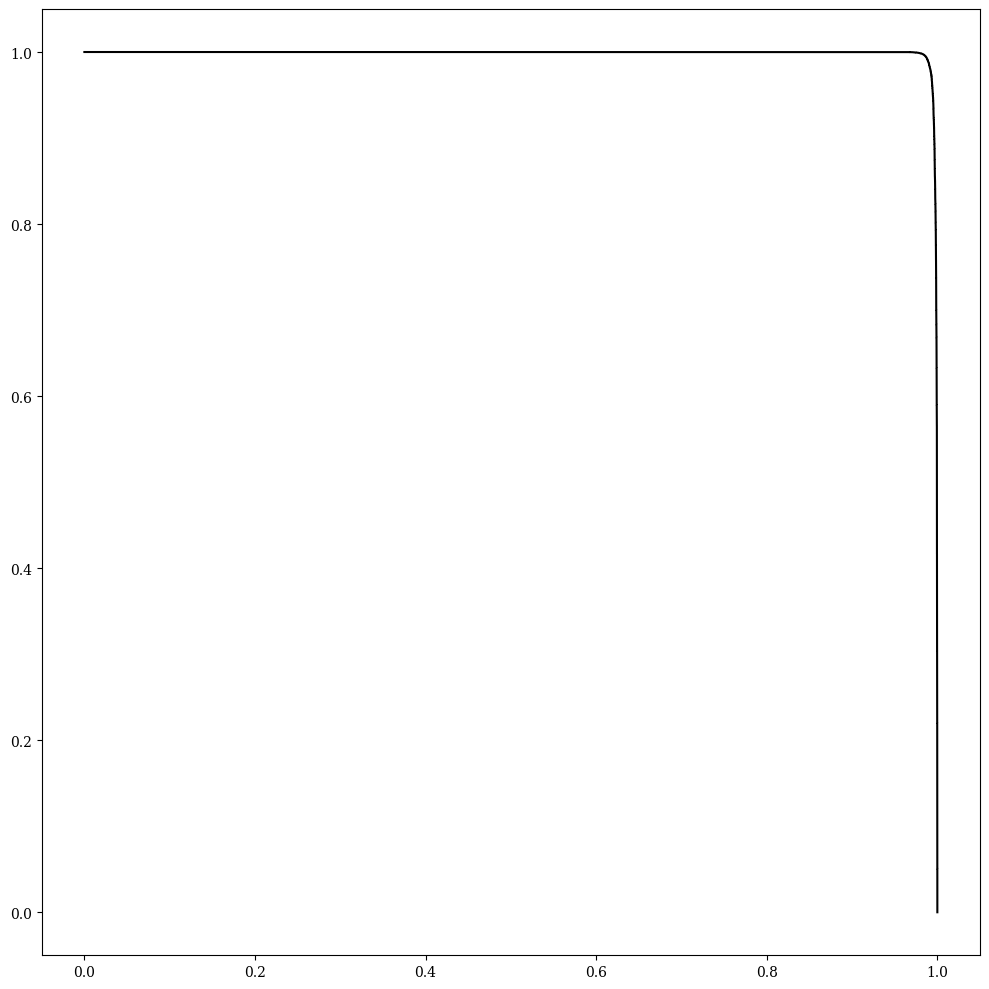

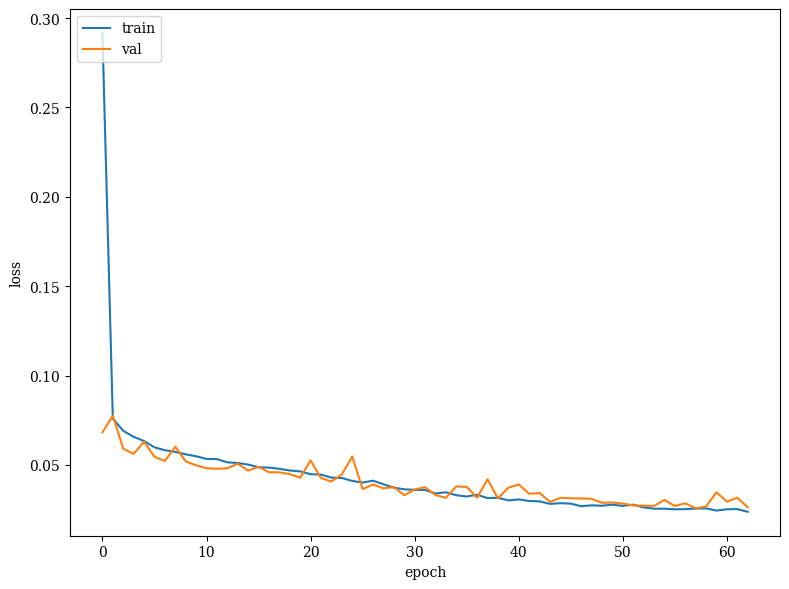

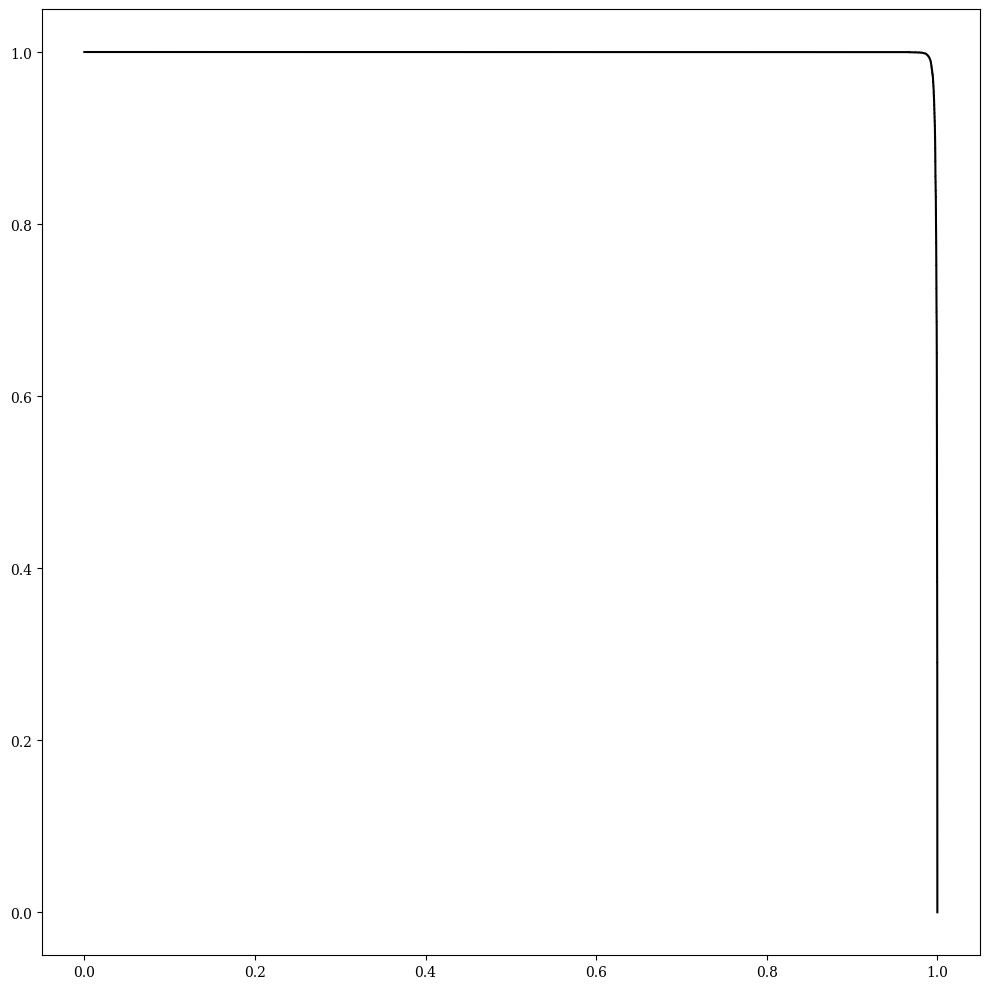

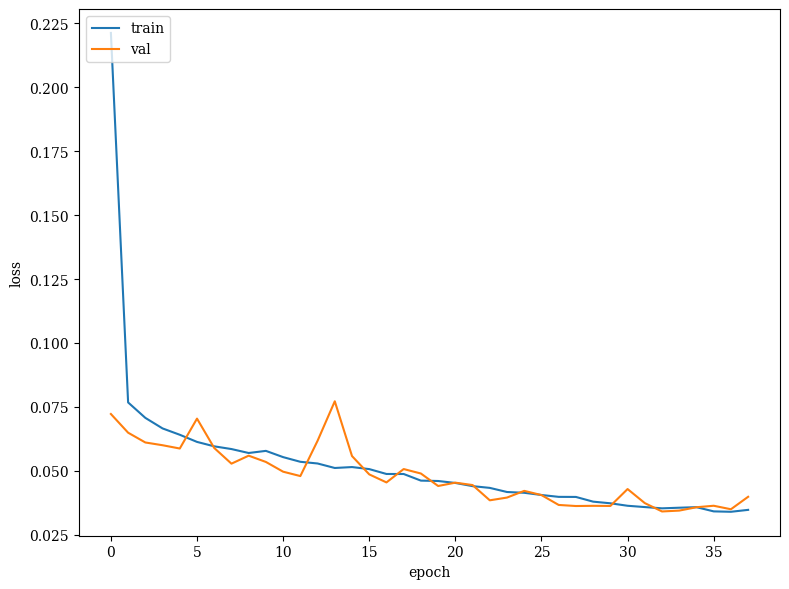

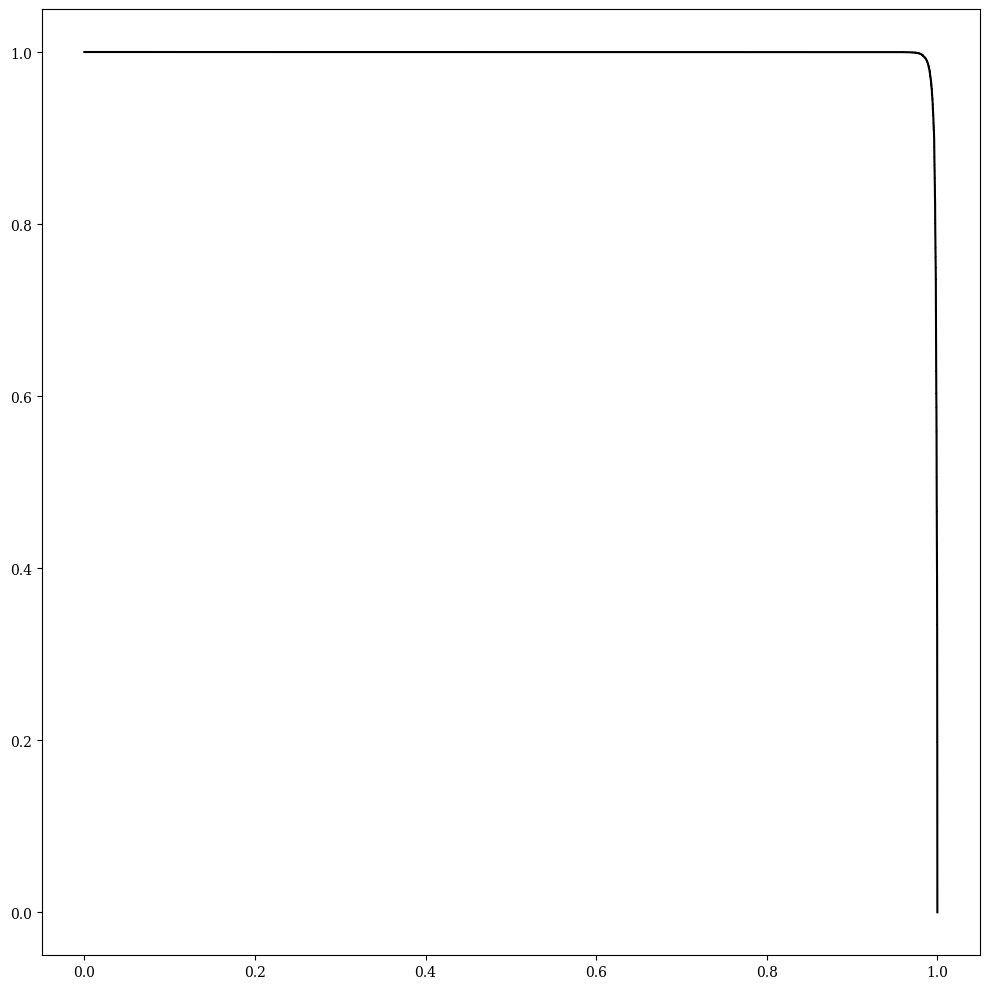

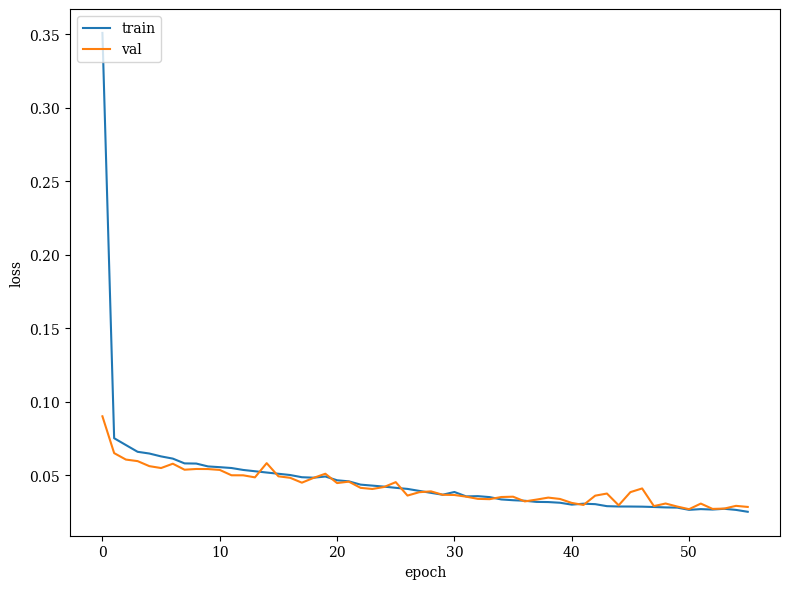

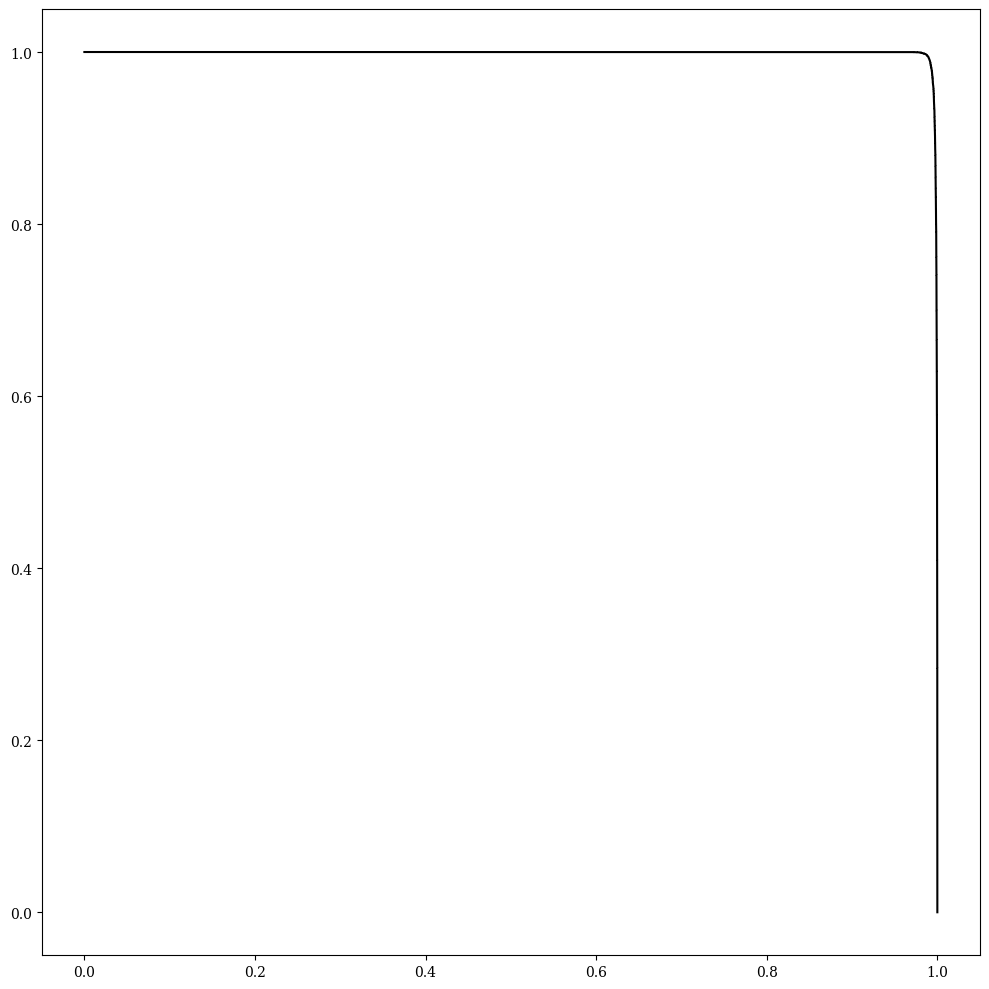

In [3]:
# Regular PFN, no spectral normalization
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-3),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = False
    train_kwargs = {"epochs":100,"verbose":1,"batch_size":512}
    pfn, auc, pfn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    pfn.save(f"keras_models_PFN/gjet_PFN_zpT_iter{i}.keras")
    del pfn
    gc.collect()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, 3)]    0           []                               
                                                                                                  
 tdist_0 (TimeDistributed)      (None, None, 60)     481         ['input[0][0]']                  
                                                                                                  
 activation_70 (Activation)     (None, None, 60)     0           ['tdist_0[0][0]']                
                                                                                                  
 tdist_1 (TimeDistributed)      (None, None, 60)     7321        ['activation_70[0][0]']          
                                                                                           

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 163ms/step - loss: 0.6124 - acc: 0.5000 - val_loss: 0.5925 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 137ms/step - loss: 0.5912 - acc: 0.5000 - val_loss: 0.5821 - val_acc: 0.5000
Epoch 3/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5791 - acc: 0.5010 - val_loss: 0.5685 - val_acc: 0.5022
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5657 - acc: 0.5061 - val_loss: 0.5528 - val_acc: 0.5122
Epoch 5/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5504 - acc: 0.5204 - val_loss: 0.5341 - val_acc: 0.5317
Epoch 6/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5332 - acc: 0.5482 - val_loss: 0.5156 - val_acc: 0.5715
Epoch 7/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5161 - acc: 0.5903 - val_loss: 0.4973 - val_acc: 0.6120
Epoch 8/150
20/20 [==============================] - 3s 134ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 6s 167ms/step - loss: 0.6155 - acc: 0.5007 - val_loss: 0.5895 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5912 - acc: 0.5005 - val_loss: 0.5794 - val_acc: 0.5006
Epoch 3/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5802 - acc: 0.5038 - val_loss: 0.5667 - val_acc: 0.5051
Epoch 4/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5658 - acc: 0.5161 - val_loss: 0.5494 - val_acc: 0.5195
Epoch 5/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5480 - acc: 0.5432 - val_loss: 0.5273 - val_acc: 0.5535
Epoch 6/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5278 - acc: 0.5837 - val_loss: 0.5059 - val_acc: 0.5986
Epoch 7/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5086 - acc: 0.6365 - val_loss: 0.4857 - val_acc: 0.6444
Epoch 8/150
20/20 [==============================] - 3s 132ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 164ms/step - loss: 0.6401 - acc: 0.5040 - val_loss: 0.6050 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5919 - acc: 0.5001 - val_loss: 0.5789 - val_acc: 0.5002
Epoch 3/150
20/20 [==============================] - 3s 139ms/step - loss: 0.5772 - acc: 0.5022 - val_loss: 0.5649 - val_acc: 0.5042
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5644 - acc: 0.5103 - val_loss: 0.5509 - val_acc: 0.5127
Epoch 5/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5502 - acc: 0.5264 - val_loss: 0.5344 - val_acc: 0.5356
Epoch 6/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5348 - acc: 0.5577 - val_loss: 0.5167 - val_acc: 0.5779
Epoch 7/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5175 - acc: 0.6041 - val_loss: 0.4973 - val_acc: 0.6328
Epoch 8/150
20/20 [==============================] - 3s 135ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 161ms/step - loss: 0.6147 - acc: 0.4999 - val_loss: 0.5894 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5868 - acc: 0.5001 - val_loss: 0.5757 - val_acc: 0.5000
Epoch 3/150
20/20 [==============================] - 3s 137ms/step - loss: 0.5724 - acc: 0.5023 - val_loss: 0.5574 - val_acc: 0.5054
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5554 - acc: 0.5141 - val_loss: 0.5375 - val_acc: 0.5271
Epoch 5/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5374 - acc: 0.5404 - val_loss: 0.5171 - val_acc: 0.5670
Epoch 6/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5190 - acc: 0.5861 - val_loss: 0.4969 - val_acc: 0.6284
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.5006 - acc: 0.6437 - val_loss: 0.4773 - val_acc: 0.6843
Epoch 8/150
20/20 [==============================] - 3s 136ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 170ms/step - loss: 0.6101 - acc: 0.5001 - val_loss: 0.5921 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 149ms/step - loss: 0.5905 - acc: 0.5000 - val_loss: 0.5810 - val_acc: 0.5002
Epoch 3/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5790 - acc: 0.5021 - val_loss: 0.5673 - val_acc: 0.5051
Epoch 4/150
20/20 [==============================] - 3s 142ms/step - loss: 0.5645 - acc: 0.5121 - val_loss: 0.5495 - val_acc: 0.5220
Epoch 5/150
20/20 [==============================] - 3s 131ms/step - loss: 0.5478 - acc: 0.5349 - val_loss: 0.5309 - val_acc: 0.5533
Epoch 6/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5299 - acc: 0.5742 - val_loss: 0.5101 - val_acc: 0.6031
Epoch 7/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5109 - acc: 0.6262 - val_loss: 0.4891 - val_acc: 0.6599
Epoch 8/150
20/20 [==============================] - 3s 131ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 167ms/step - loss: 0.6258 - acc: 0.5048 - val_loss: 0.5904 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5908 - acc: 0.5002 - val_loss: 0.5831 - val_acc: 0.5005
Epoch 3/150
20/20 [==============================] - 3s 136ms/step - loss: 0.5816 - acc: 0.5037 - val_loss: 0.5706 - val_acc: 0.5066
Epoch 4/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5693 - acc: 0.5136 - val_loss: 0.5556 - val_acc: 0.5177
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.5549 - acc: 0.5329 - val_loss: 0.5380 - val_acc: 0.5421
Epoch 6/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5381 - acc: 0.5686 - val_loss: 0.5187 - val_acc: 0.5889
Epoch 7/150
20/20 [==============================] - 3s 135ms/step - loss: 0.5191 - acc: 0.6193 - val_loss: 0.4958 - val_acc: 0.6372
Epoch 8/150
20/20 [==============================] - 3s 133ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 163ms/step - loss: 0.6167 - acc: 0.5001 - val_loss: 0.5920 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5903 - acc: 0.5001 - val_loss: 0.5805 - val_acc: 0.5002
Epoch 3/150
20/20 [==============================] - 3s 145ms/step - loss: 0.5787 - acc: 0.5018 - val_loss: 0.5671 - val_acc: 0.5048
Epoch 4/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5652 - acc: 0.5110 - val_loss: 0.5505 - val_acc: 0.5197
Epoch 5/150
20/20 [==============================] - 3s 139ms/step - loss: 0.5489 - acc: 0.5318 - val_loss: 0.5294 - val_acc: 0.5529
Epoch 6/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5298 - acc: 0.5703 - val_loss: 0.5075 - val_acc: 0.6059
Epoch 7/150
20/20 [==============================] - 3s 138ms/step - loss: 0.5094 - acc: 0.6268 - val_loss: 0.4861 - val_acc: 0.6696
Epoch 8/150
20/20 [==============================] - 3s 134ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 162ms/step - loss: 0.6207 - acc: 0.5004 - val_loss: 0.5907 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5893 - acc: 0.5001 - val_loss: 0.5795 - val_acc: 0.5000
Epoch 3/150
20/20 [==============================] - 3s 145ms/step - loss: 0.5779 - acc: 0.5025 - val_loss: 0.5650 - val_acc: 0.5079
Epoch 4/150
20/20 [==============================] - 3s 130ms/step - loss: 0.5641 - acc: 0.5134 - val_loss: 0.5483 - val_acc: 0.5283
Epoch 5/150
20/20 [==============================] - 3s 131ms/step - loss: 0.5470 - acc: 0.5370 - val_loss: 0.5284 - val_acc: 0.5586
Epoch 6/150
20/20 [==============================] - 3s 131ms/step - loss: 0.5283 - acc: 0.5756 - val_loss: 0.5081 - val_acc: 0.6044
Epoch 7/150
20/20 [==============================] - 3s 130ms/step - loss: 0.5094 - acc: 0.6293 - val_loss: 0.4859 - val_acc: 0.6725
Epoch 8/150
20/20 [==============================] - 3s 132ms/step - 

/home/sbrightt/.conda/envs/eflow/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/150
20/20 [==============================] - 5s 158ms/step - loss: 0.6492 - acc: 0.5028 - val_loss: 0.6048 - val_acc: 0.5000
Epoch 2/150
20/20 [==============================] - 3s 134ms/step - loss: 0.5932 - acc: 0.5002 - val_loss: 0.5822 - val_acc: 0.5000
Epoch 3/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5814 - acc: 0.5011 - val_loss: 0.5704 - val_acc: 0.5018
Epoch 4/150
20/20 [==============================] - 3s 140ms/step - loss: 0.5690 - acc: 0.5055 - val_loss: 0.5560 - val_acc: 0.5082
Epoch 5/150
20/20 [==============================] - 3s 132ms/step - loss: 0.5539 - acc: 0.5180 - val_loss: 0.5380 - val_acc: 0.5273
Epoch 6/150
20/20 [==============================] - 3s 147ms/step - loss: 0.5370 - acc: 0.5443 - val_loss: 0.5182 - val_acc: 0.5655
Epoch 7/150
20/20 [==============================] - 3s 133ms/step - loss: 0.5197 - acc: 0.5826 - val_loss: 0.4999 - val_acc: 0.6137
Epoch 8/150
20/20 [==============================] - 3s 144ms/step - 

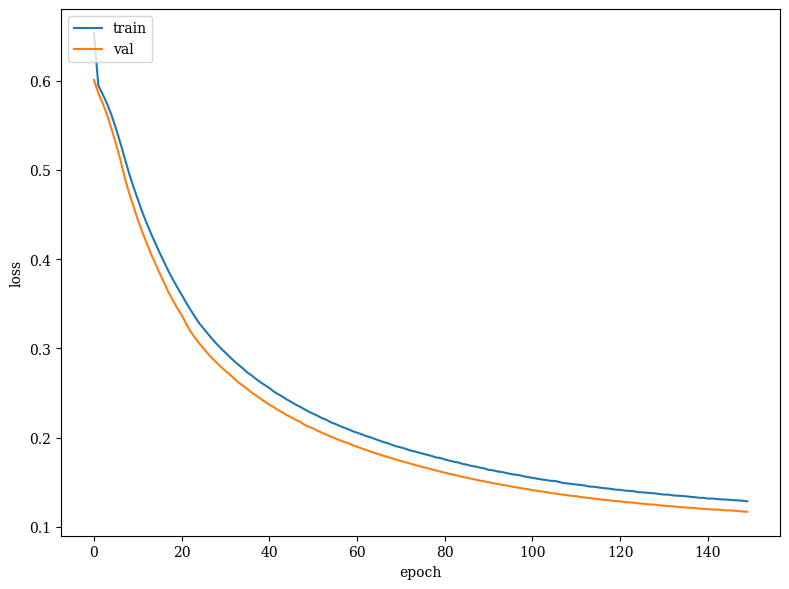

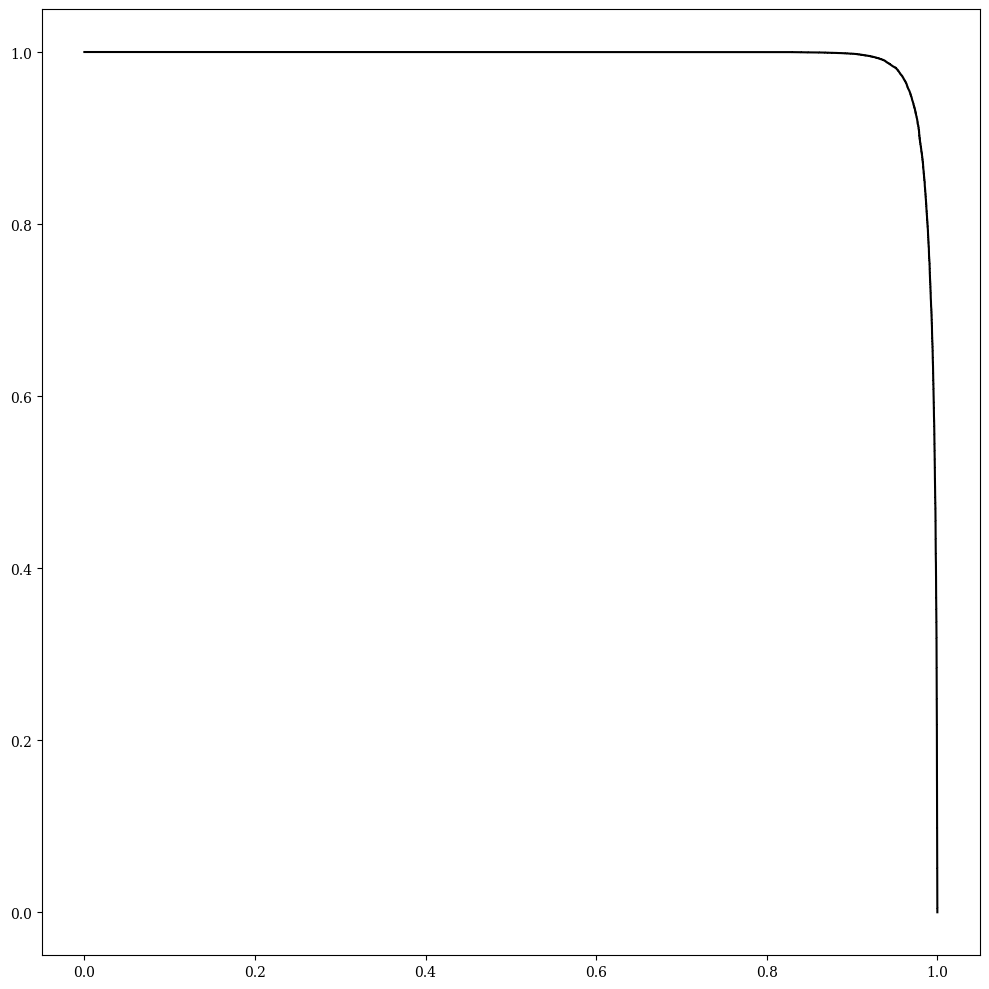

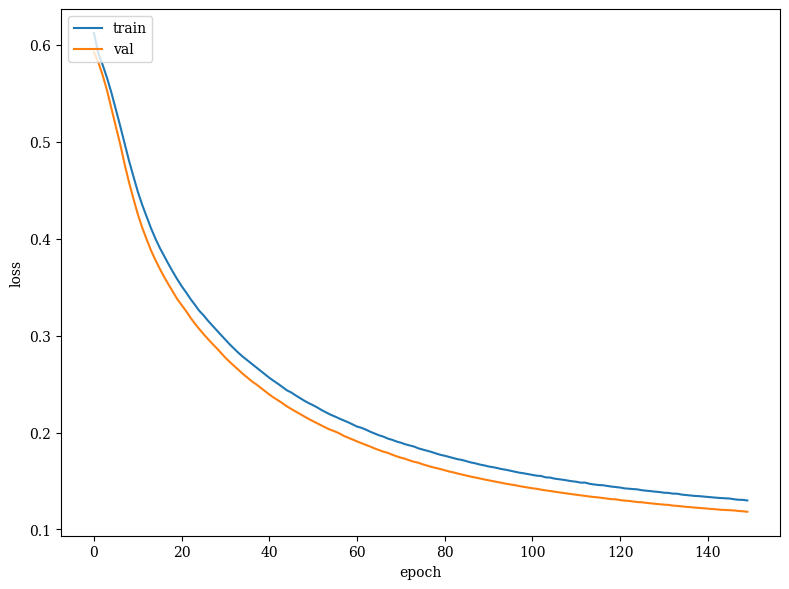

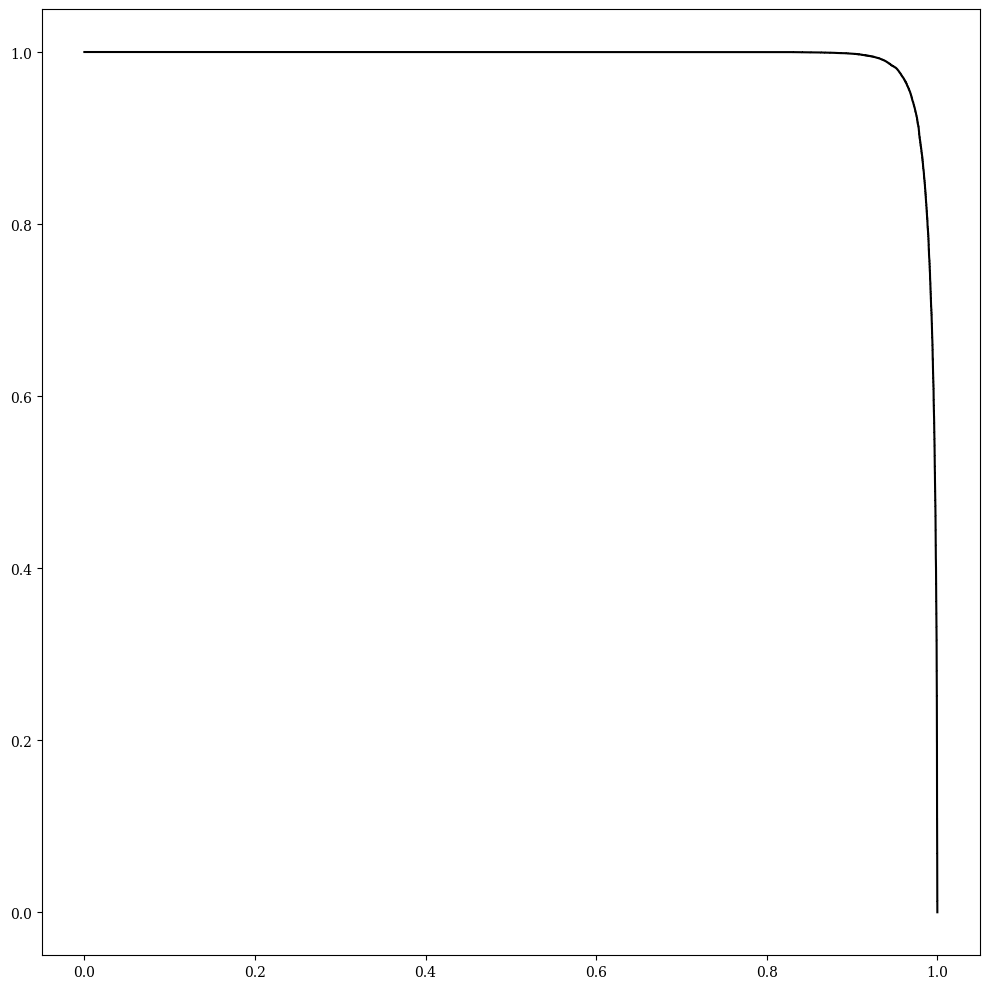

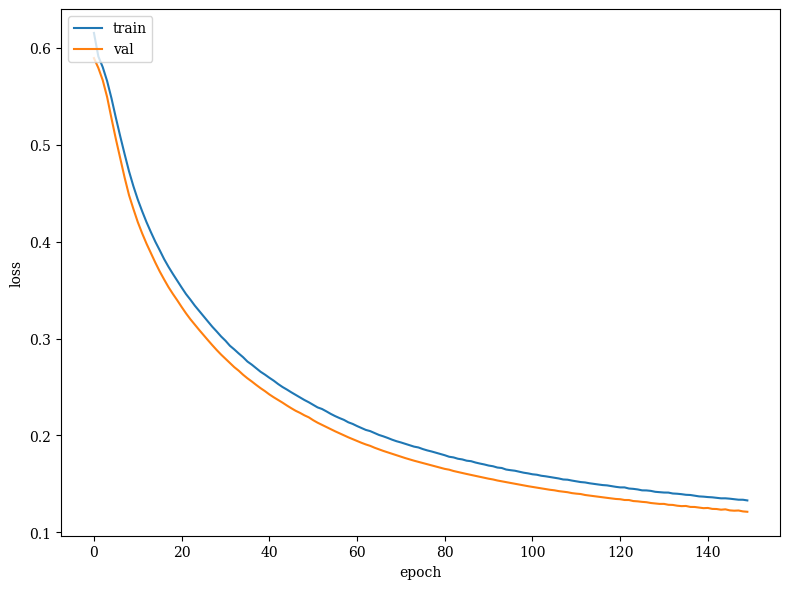

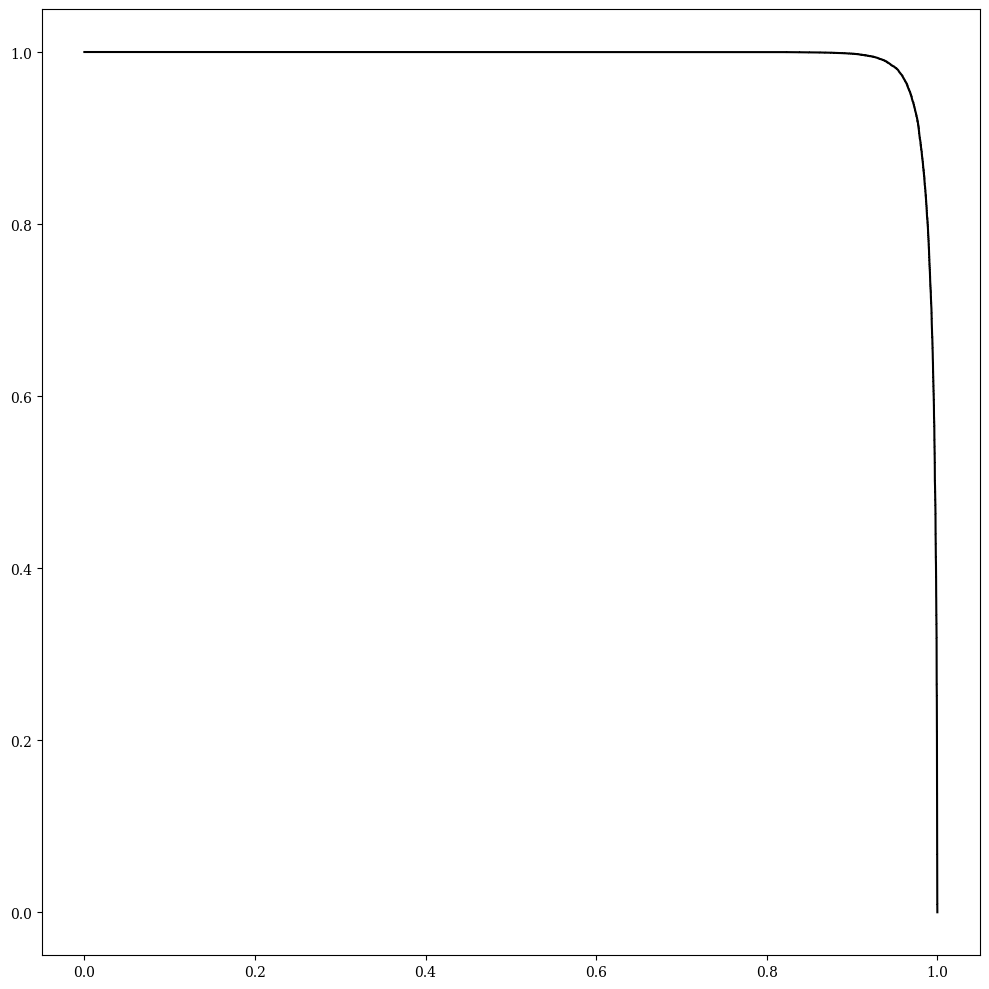

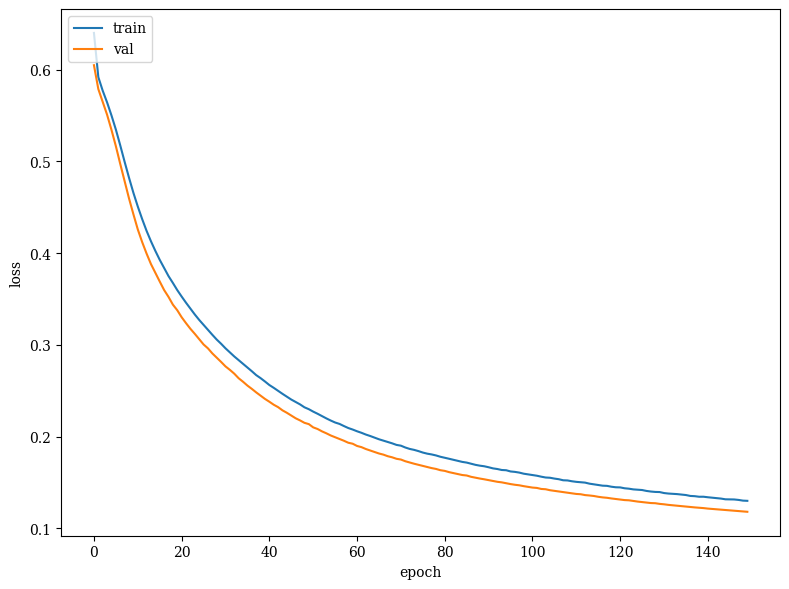

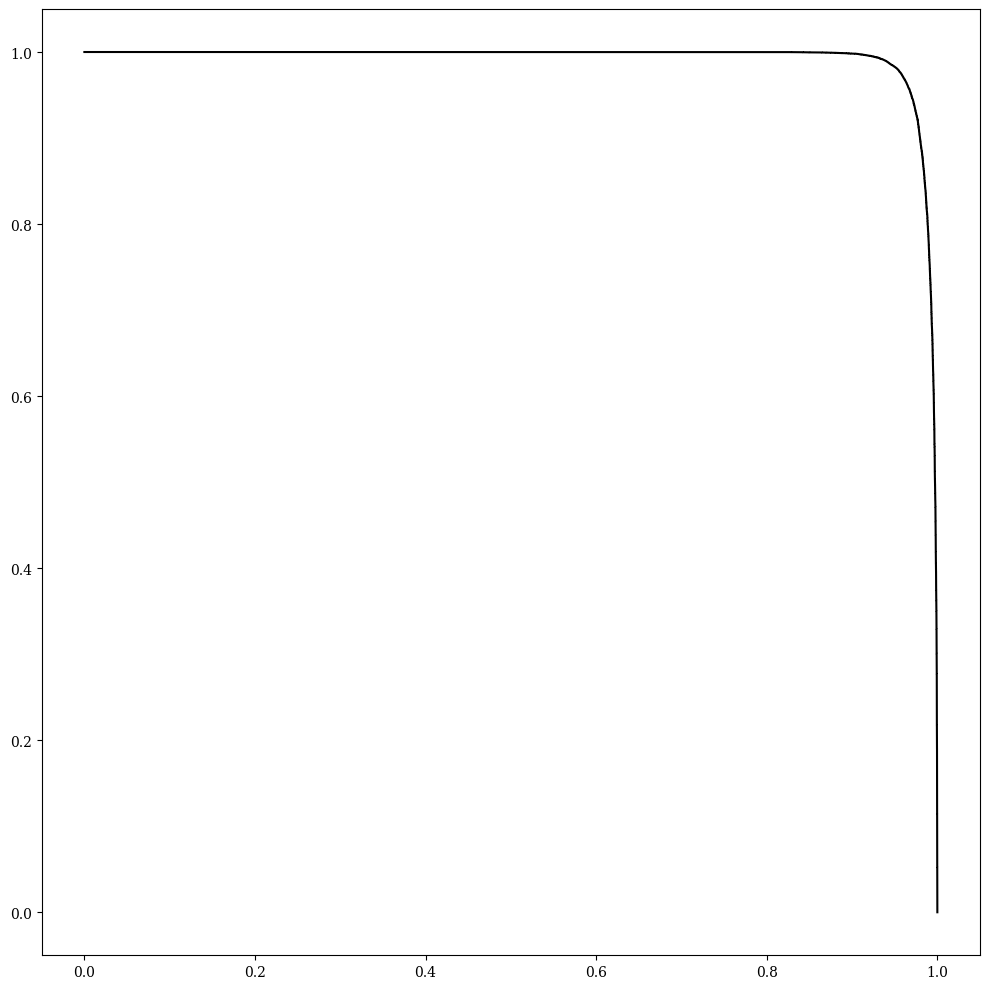

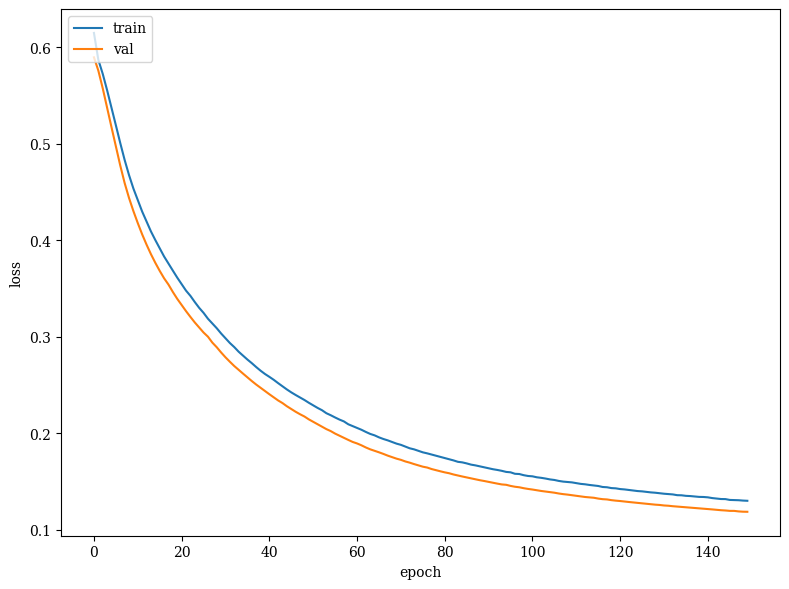

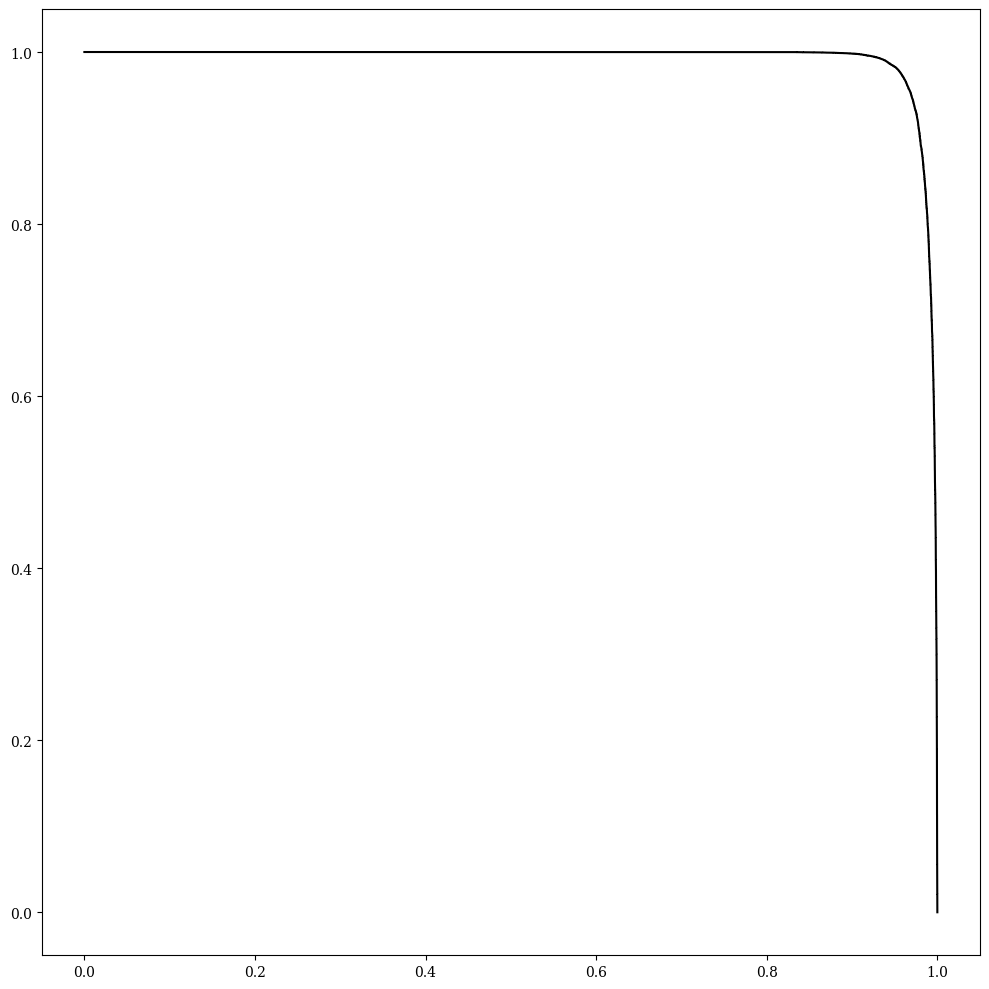

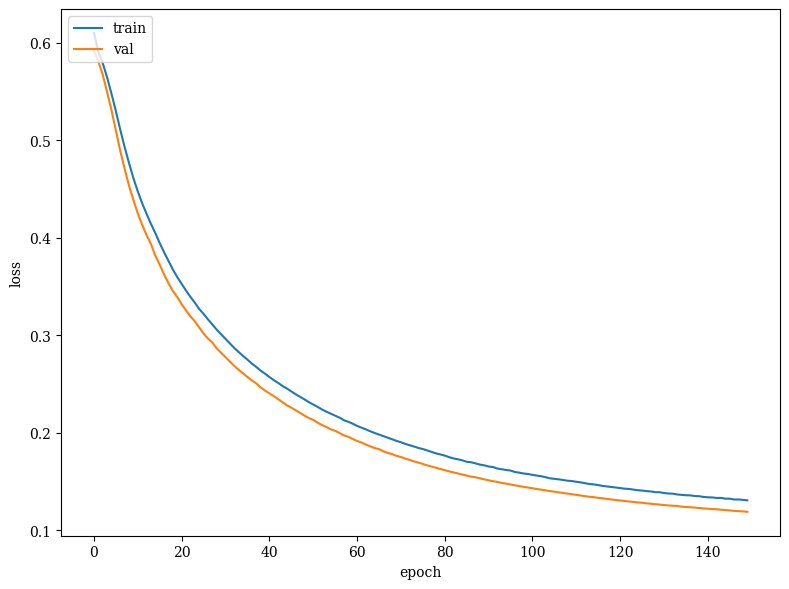

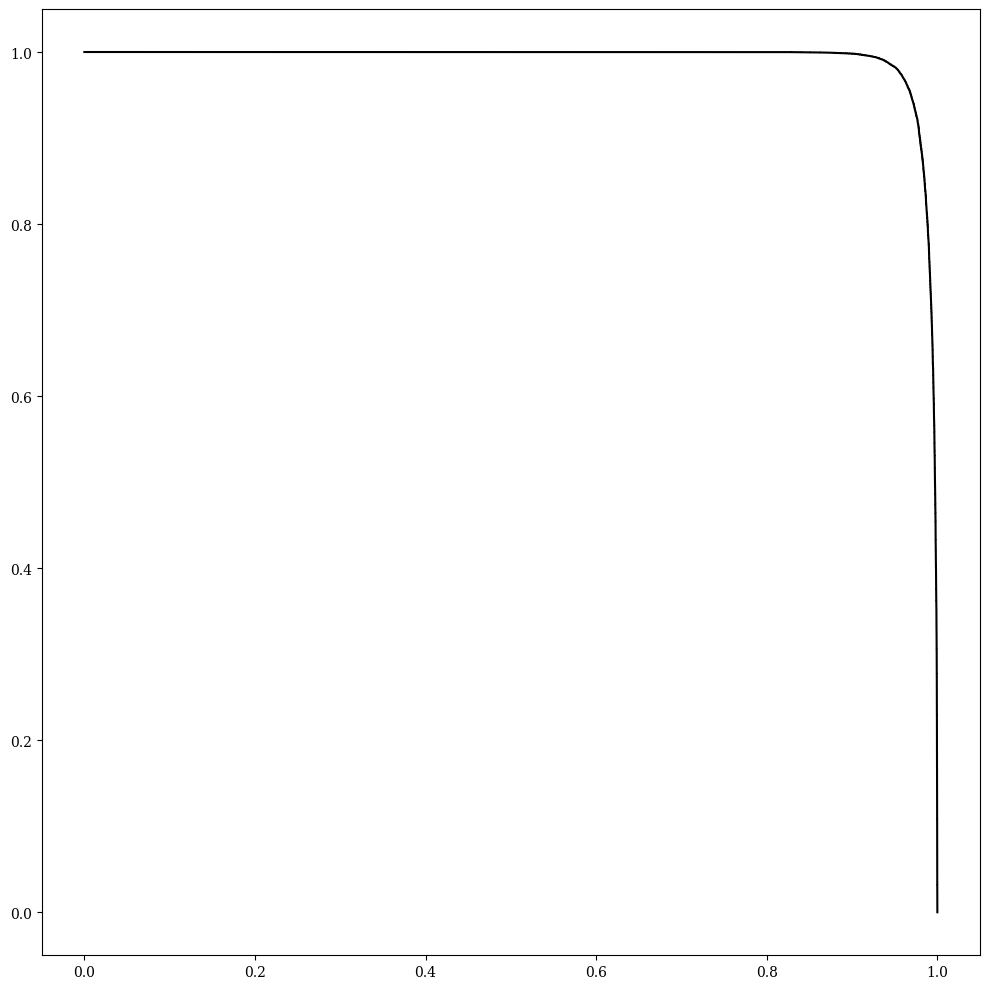

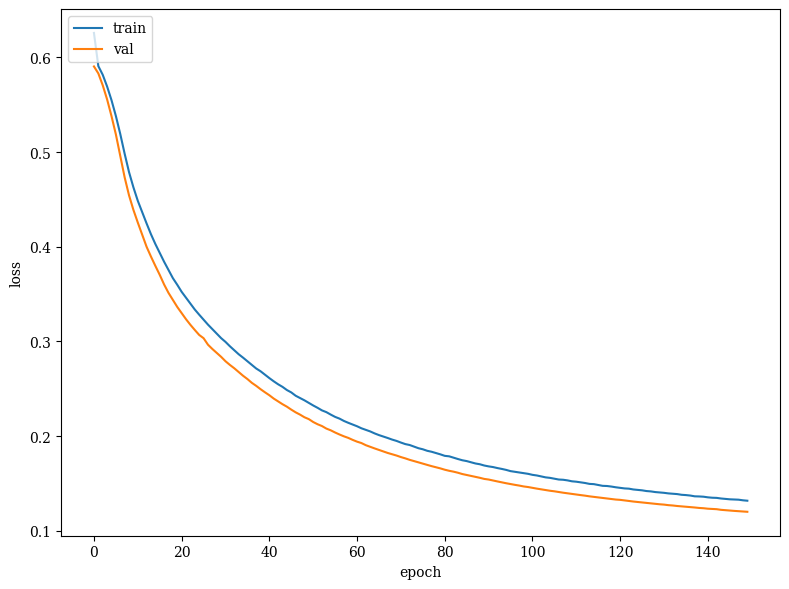

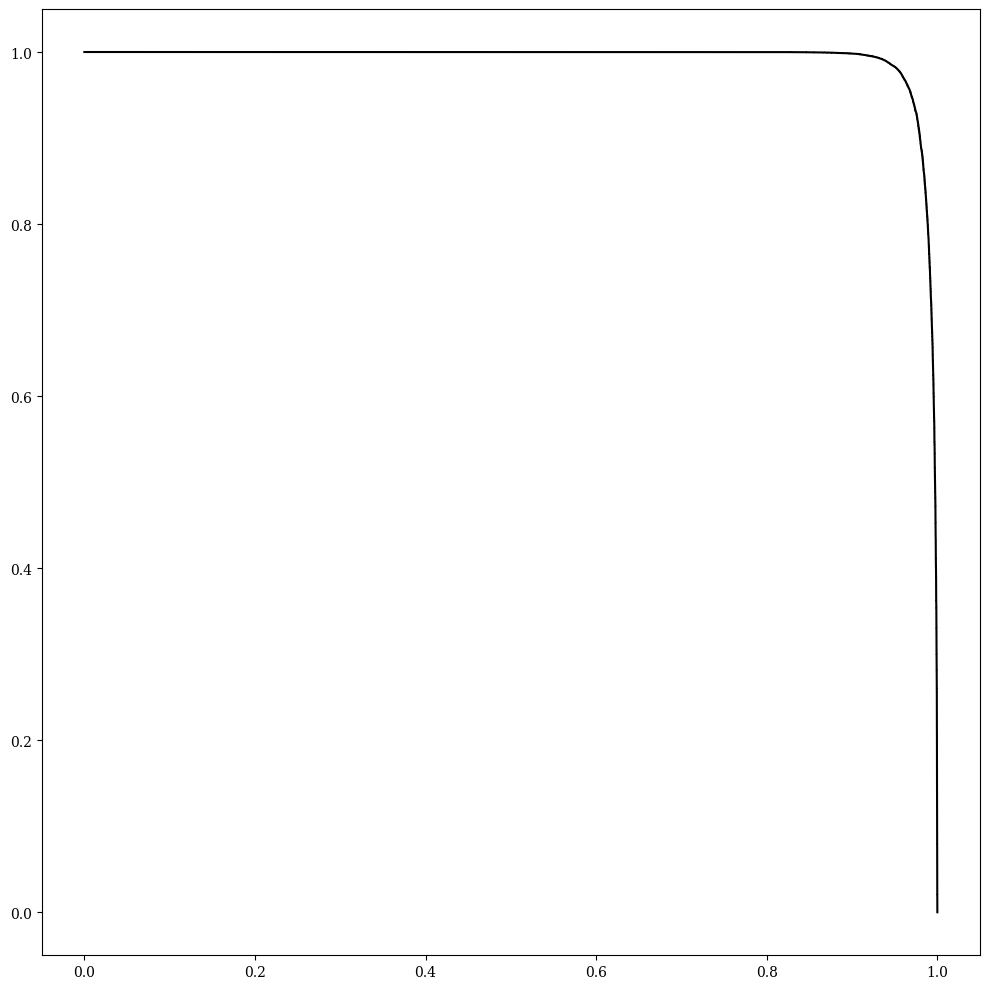

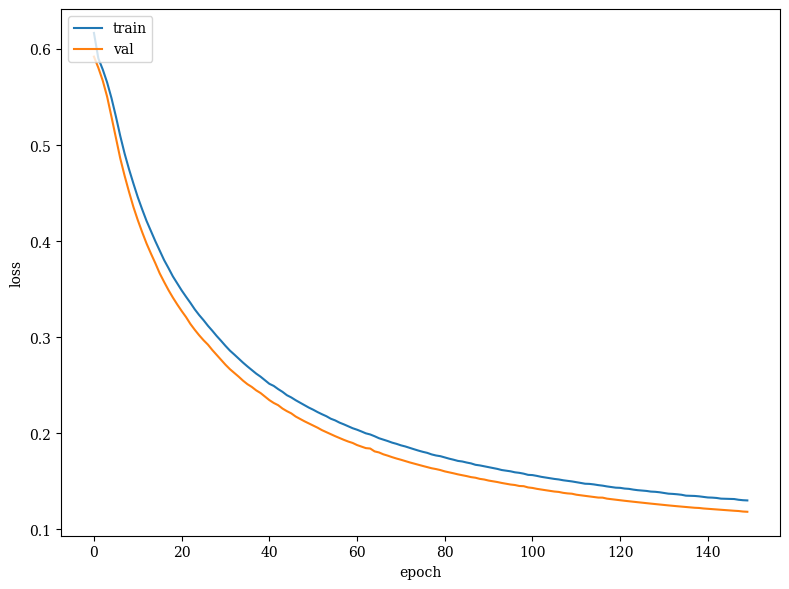

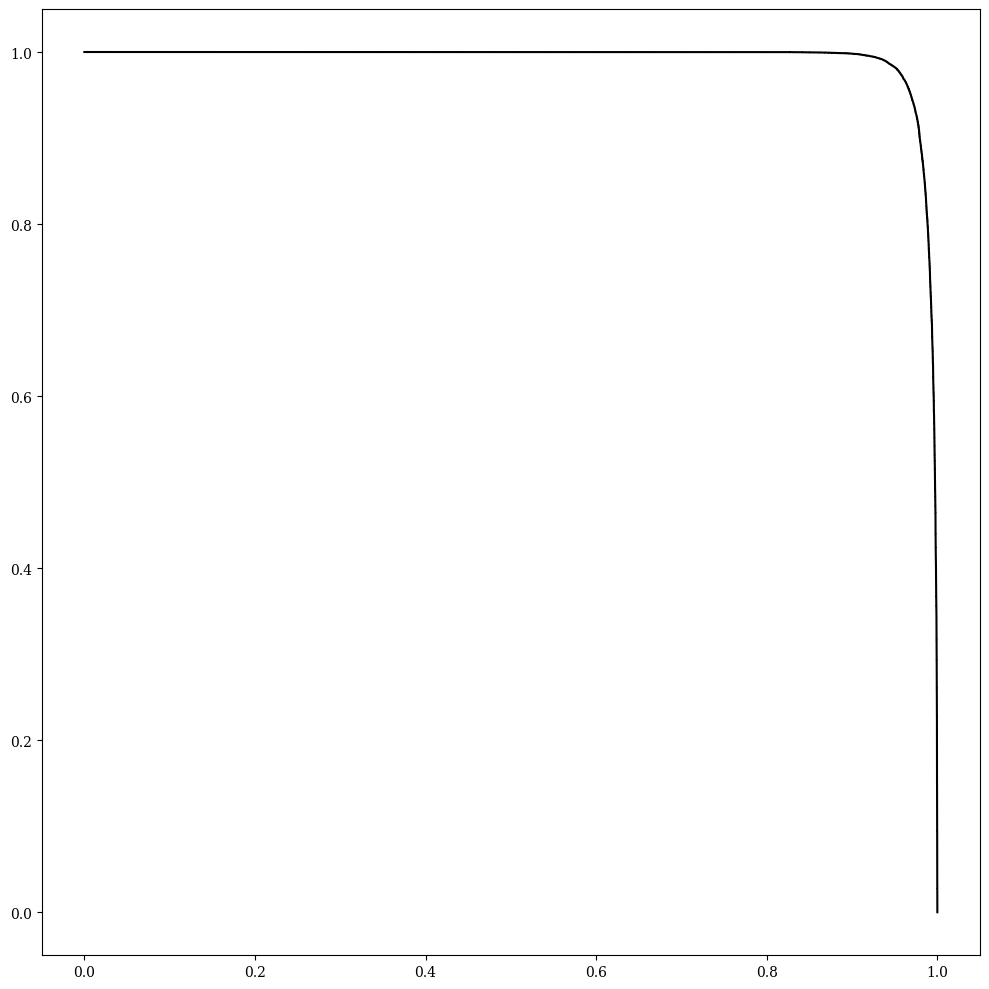

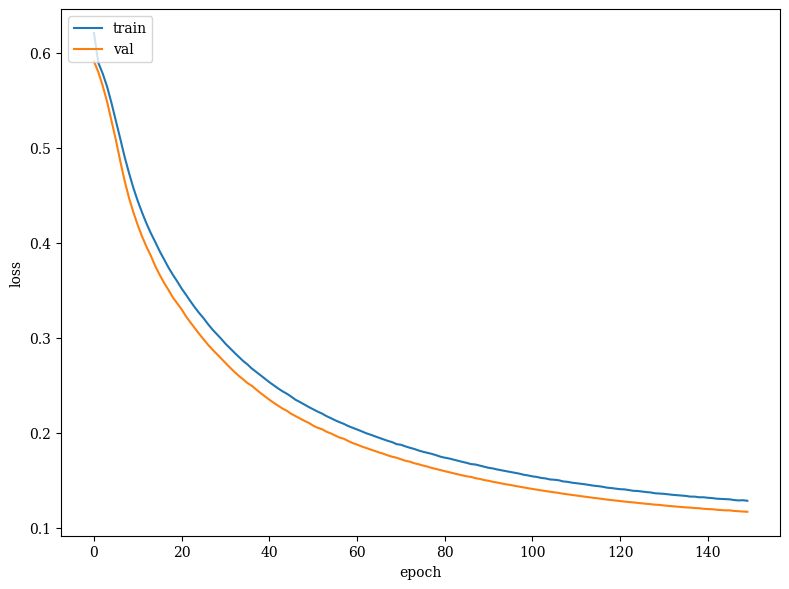

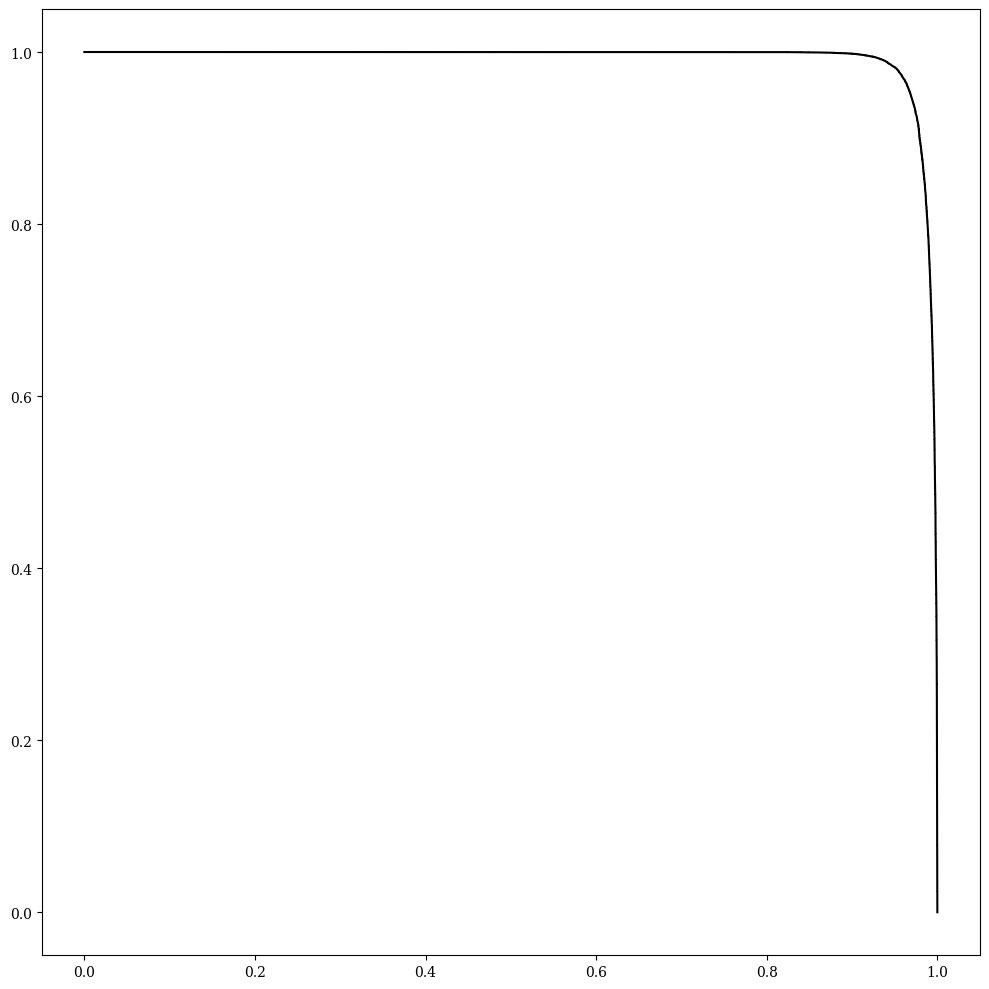

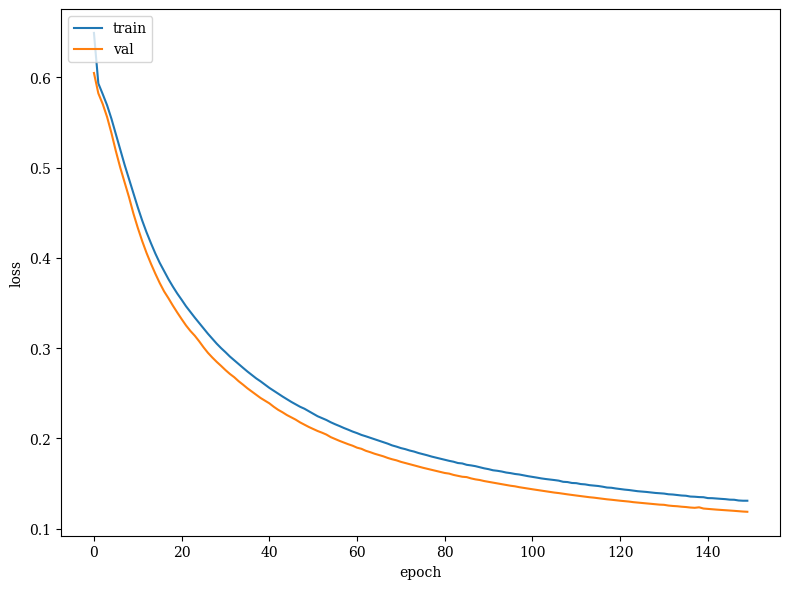

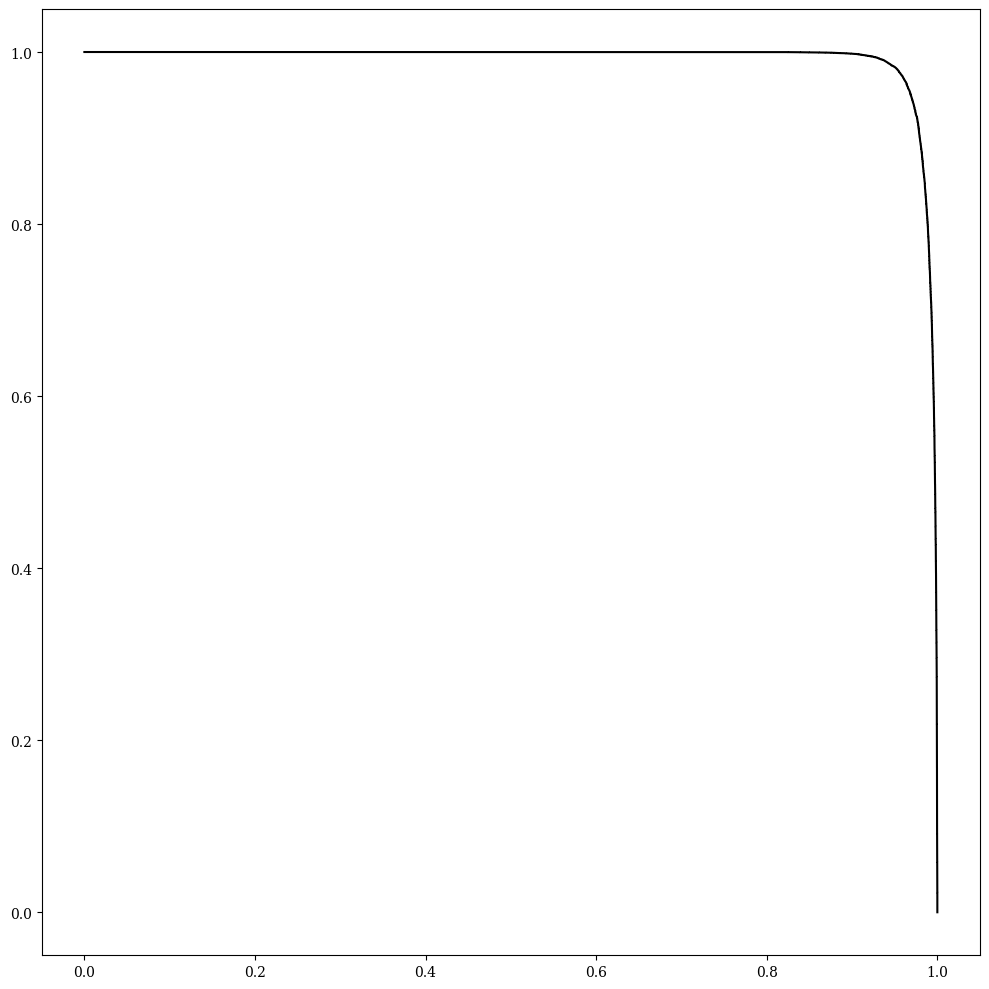

In [4]:
# Spectral PFN
for i in range(10):
    loss = BinaryCrossentropy(from_logits=False)
    #out_act = keras.activations.linear
    model_kwargs = {"Phi_sizes":(60,60,60), "F_sizes":(80,80,80),
                    "F_dropouts":0.1,
                    "input_dim":3,
                    "output_dim":1,"output_act":"sigmoid",
                    "patience":5,
                    "optimizer":Adam(1e-4),
                    "loss":loss,
                    "summary":True}
    model_kwargs['spectral'] = True
    train_kwargs = {"epochs":150,"verbose":1,"batch_size":10000}
    pfn, auc, pfn_fp, efn_tp, threshs = train_pfn((train,train_labels),
                                                  (test,test_labels),
                                                  (val,val_labels),
                                                  model_kwargs,
                                                  train_kwargs,
                                                  plot=True)
    pfn.save(f"keras_models_PFN/gjet_spectralPFN_zpT_iter{i}.keras")
    del pfn
    gc.collect()